In [2]:
import numpy as np
import pandas as pd
import scipy.special as special
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numpy import sqrt, sin, cos, pi
from scipy.interpolate import interp1d
from datetime import timedelta, datetime, date, time

from astropy.time import Time
from astropy import units as u
from poliastro.twobody import Orbit
from poliastro.bodies import Earth, Mars, Sun, Jupiter, Venus
from poliastro.plotting import OrbitPlotter3D, OrbitPlotter2D

import utils.metrics as metrics
import utils.physical_utils as physical_utils
import preprocessing.extra_points_removing as epr
import preprocessing.data_loading as data_loading
from utils.math_utils import normalize, moving_average, mean_without_k_outlies

In [310]:
df = data_loading.load_train_dataframe()
df_test = data_loading.load_test_dataframe()

#df = epr.arg_decomposition_into_sin_cos(df)
df['nu+argp'] = df['nu'] + df['argp']

real_columns = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
sim_columns = ['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']

df.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,delta_time,a,ecc,inc,raan,argp,nu,error,h,nu+argp
0,0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,...,2803.000,35750.514004,0.270500,1.162389,4.703662,4.188790,7.351826e-17,0.000535,26080.000000,4.188790
1,1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,...,2803.000,35748.799206,0.270473,1.162382,4.703637,4.188586,4.665457e-01,0.002533,26686.896582,4.655131
2,2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,...,2803.001,35750.632657,0.270525,1.162386,4.703614,4.188503,8.948489e-01,0.001743,28338.043990,5.083352
3,3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,...,2803.000,35753.337417,0.270576,1.162393,4.703602,4.188621,1.266563e+00,0.000915,30651.371610,5.455184
4,4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,...,2803.001,35755.129047,0.270593,1.162397,4.703597,4.188767,1.582752e+00,0.000948,33244.665434,5.771519


### Выделяем спутники в отдельные таблицы

In [311]:
sat_list=[]
for sat_id in range(600):
    sat={}
    sat['sat_id'] = sat_id
    sat['d'] = df[df['sat_id']==sat_id]
    sat_list.append(sat)
    

# Решаем проблему с непрерывностью argp
for sat_id in range(600):
    sat=sat_list[sat_id]
    d = sat['d']
    
    if max(d['argp'])>6 * min(d['argp'])<0.3:
        d.loc[:,'argp'] = d['argp'] + (d['argp'] < np.mean(d['argp'])) * np.pi*2
    
    sat['d'] = d
    
# Усредняем параметры орбиты
averaged_columns = ['a', 'ecc', 'inc', 'raan', 'argp']
for sat_id in range(600):
    sat=sat_list[sat_id]
    d = sat['d']
    
    main_part = d[averaged_columns][:len(d)//24*24].to_numpy().reshape((-1, 24, 5))
    residue = d[averaged_columns][-24:].to_numpy()

    averaged_values = np.apply_along_axis(mean_without_k_outlies, 1, main_part)
    averaged_values = np.append(averaged_values, 
                                np.apply_along_axis(mean_without_k_outlies, 0, residue).reshape((1, 5)), axis=0)
    
    
    x = np.linspace(0, 1, len(averaged_values))

    a = interp1d(x, averaged_values[:,0], kind='cubic')
    a = a(np.linspace(0, 1, len(d)))

    ecc = interp1d(x, averaged_values[:,1], kind='cubic')
    ecc = ecc(np.linspace(0, 1, len(d)))

    inc = interp1d(x, averaged_values[:,2], kind='cubic')
    inc = inc(np.linspace(0, 1, len(d)))

    raan = interp1d(x, averaged_values[:,3], kind='cubic')
    raan = raan(np.linspace(0, 1, len(d)))

    argp = interp1d(x, averaged_values[:,4], kind='cubic')
    argp = argp(np.linspace(0, 1, len(d)))

    d.loc[:,['a']]=a
    d.loc[:,['ecc']]=ecc
    d.loc[:,['inc']]=inc
    d.loc[:,['raan']]=raan
    d.loc[:,['argp']]=argp
    d.loc[:,['nu']] = d['nu+argp']-d['argp']
    
    sat['d'] = d

C:\Users\79105\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Определение периода обращения

In [312]:
d.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,delta_time,a,ecc,inc,raan,argp,nu,error,h,nu+argp
647619,1232297,2014-01-01 00:00:00.000000000,599,2405.281158,17976.480941,-1632.438523,5.030929,-0.759540,-0.951371,2417.118356,...,1490.638,23464.322045,0.223819,2.935665,5.025285,3.596297,6.283185,0.001225,18210.000000,9.878564
647620,1232298,2014-01-01 00:24:50.638000128,599,9552.243629,15579.071577,-2899.243642,4.447595,-2.405280,-0.729643,9560.455709,...,1490.638,23464.322072,0.223820,2.935666,5.025319,3.596366,0.418861,0.000439,18502.930666,4.014622
647621,1232299,2014-01-01 00:49:41.275000064,599,15400.509670,11033.859665,-3769.814003,3.336788,-3.600366,-0.431981,15405.750729,...,1490.637,23464.322103,0.223820,2.935667,5.025353,3.596436,0.813320,0.000367,19316.657444,4.409396
647622,1232300,2014-01-01 01:14:31.912999936,599,19394.715528,5132.171277,-4184.571799,2.011097,-4.225056,-0.128255,19398.279932,...,1490.638,23464.322138,0.223821,2.935668,5.025388,3.596505,1.168930,0.000832,20494.018971,4.765225
647623,1232301,2014-01-01 01:39:22.550000128,599,21416.468928,-1314.106108,-4172.168732,0.721898,-4.352432,0.136242,21419.290342,...,1490.637,23464.322176,0.223822,2.935668,5.025422,3.596575,1.482781,0.000846,21858.614048,5.079208


In [332]:
def get_ellipse_area(a, e, t0, t1):
    bad_gap = (t1>np.pi) * (t0<np.pi)
    
    b = a*np.sqrt(1-e**2)
    
    E0 = 2*np.arctan(np.sqrt((1-e)/(1+e)) * np.tan(t0/2))
    E1 = 2*np.arctan(np.sqrt((1-e)/(1+e)) * np.tan(t1/2))
    
    S0 = 0.5 * a * b * (E0-e*np.sin(E0))
    S1 = 0.5 * a * b * (E1-e*np.sin(E1))
    S2 = bad_gap * a*b*np.pi
    
    s = S1 - S0 + S2
    return s / (a*b*np.pi)

C:\Users\79105\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\79105\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



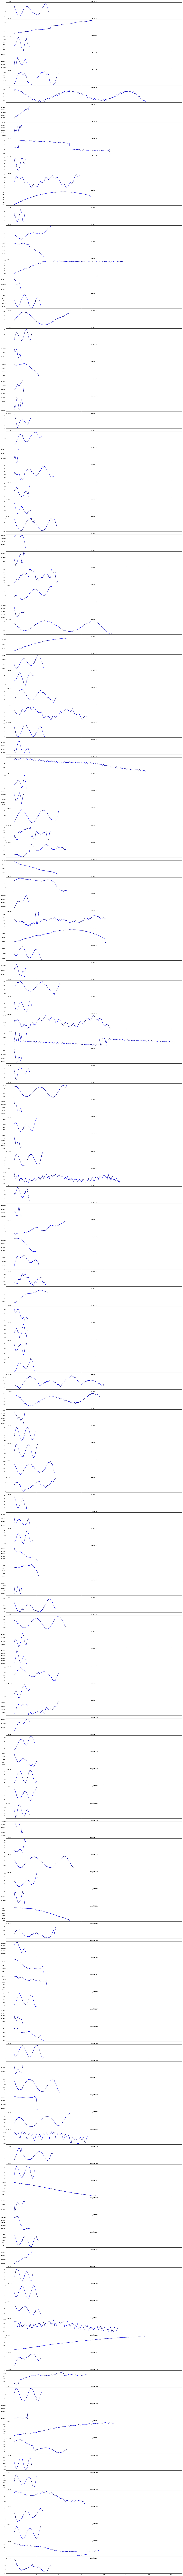

In [340]:
fig, axs = plt.subplots(150, figsize = (30, 450), sharex=True)

for i in range(150):
    sat = sat_list[i]['d']
    
    a = sat[['x', 'y', 'z']].to_numpy()
    b = sat[['x', 'y', 'z']].shift(-1).to_numpy()
    delta_t = np.arccos(np.sum(a * b, axis=1) / (np.sqrt(np.sum(a**2, axis=1)) * np.sqrt(np.sum(b**2, axis=1))))
    sat['delta_t'] = delta_t

    sat['area'] = abs(get_ellipse_area(sat.a, sat.ecc, sat.nu, sat.nu+sat.delta_t))
    
    d=sat
    main_part = d[['area']][:len(d)//24*24].to_numpy().reshape((-1, 24, 1))
    averaged_values = np.apply_along_axis(mean_without_k_outlies, 1, main_part)
    
    y = d.delta_time.iloc[0] / averaged_values
    n = len(y)
    x = np.linspace(0,n,num=n)
    
    axs[i].set_title('subplot '+str(i))
    axs[i].plot(x, y, '-bx')
    
    #x = np.linspace(0,n,num=len(sat['ecc']))
    #axs[i].plot(x,normalize(sat['ecc'], 1), 'r')

plt.show()